In [37]:
!pip install langchain langchain_core langchain_groq langchain_community langgraph

In [38]:
 import os
 from typing import TypedDict, Annotated, List
 from langgraph.graph import StateGraph, END
 from langchain_core.messages import HumanMessage, AIMessage
 from langchain_core.prompts import ChatPromptTemplate, ChatMessagePromptTemplate
 from langchain_core.runnables.graph import MermaidDrawMethod
 from IPython.display import Image, display

In [39]:
 class PlannerState(TypedDict):
  messages : Annotated[List[HumanMessage | AIMessage], "the messages in the conversation"]
  city : str
  interests: List[str]
  itinerary : str

In [40]:
 from langchain_groq import ChatGroq
 llm = ChatGroq(
     temperature = 0,
     groq_api_key = "your_api_key",
     model_name = "meta-llama/llama-4-scout-17b-16e-instruct"
 )
 result = llm.invoke("What is Indus")
 result.content

"The Indus River! \n\nThe Indus River is one of the longest and most iconic rivers in Asia, stretching approximately 3,180 kilometers (1,975 miles) from its origin in the Tibetan Plateau to its mouth in the Arabian Sea. Here are some key facts about the Indus:\n\n**Geography and Course**\n\nThe Indus River originates in the Tibetan Plateau, specifically in the Ngari Prefecture of Tibet Autonomous Region, China. It flows northwest through the Indian-administered region of Jammu and Kashmir and then enters Pakistan, where it flows southward through the country. The river passes through several major cities, including Skardu, Naran, and Hyderabad, before emptying into the Arabian Sea.\n\n**Importance and Significance**\n\nThe Indus River is a vital source of water, food, and livelihood for millions of people in India and Pakistan. It supports:\n\n1. **Agriculture**: The Indus River is the backbone of agriculture in Pakistan and northwestern India, with crops like cotton, wheat, rice, and 

In [41]:
 Itenary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests: {interests}. Provide a brief, bulleted itinerary."),
    ("human", "Create an itinerary for my day trip.")
 ])

In [46]:
 def input_city(state: PlannerState) -> PlannerState:
    print("Please mention the city you want to visit")
    user_message = input("Your Input: ")
    return {
        **state,
        "city": user_message,
        "messages": state.get("messages", []) + [HumanMessage(content=user_message)]
    }


 def input_interests(state: PlannerState) -> PlannerState:
    print(f"Please enter your interests for the trip to: {state['city']}")
    user_message = input("Your Input: ")
    return {
        **state,
        "interests": [interest.strip() for interest in user_message.split(',')],
        "messages": state.get("messages", []) + [HumanMessage(content=user_message)]
    }


 def create_itinerary(state: PlannerState) -> PlannerState:
    print(
        f"Creating an itinerary for: {state['city']} "
        f"based on interests: {', '.join(state['interests'])}"
    )

    response = llm.invoke(
        Itenary_prompt.format_prompt(
            city=state["city"],
            interests=state["interests"]
        ).to_messages()
    )

    print("\nFinal Itinerary:")
    print(response.content)

    return {
        **state,
        "messages": state.get("messages", []) + [AIMessage(content=response.content)],
        "itinerary": response.content,
    }


In [48]:
workflow = StateGraph(PlannerState)

workflow.add_node("input_city", input_city)
workflow.add_node("input_interests", input_interests)
workflow.add_node("create_itinerary", create_itinerary)

workflow.set_entry_point("input_city")

workflow.add_edge("input_city", "input_interests")
workflow.add_edge("input_interests", "create_itinerary")
workflow.add_edge("create_itinerary", END)

app = workflow.compile()


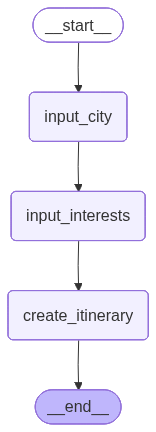

In [49]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [52]:
def travel_planner(user_request: str):
  print(f"Initial Request: {user_request}\n")
  state={
      "messages": [HumanMessage(content=user_request)],
      "city":"",
      "Interests":[],
      "itinerary":""
  }
  for output in app.stream(state):
    pass

In [53]:
user_request = "I wanna plan a night trip"
travel_planner(user_request)

Initial Request: I wanna plan a night trip

Please mention the city you want to visit
Your Input: Lahore
Please enter your interests for the trip to: Lahore
Your Input: Lahore fort, shalamar gardens
Creating an itinerary for: Lahore based on interests: Lahore fort, shalamar gardens

Final Itinerary:
Here's a suggested itinerary for your day trip to Lahore:

* **9:00 AM - 10:00 AM:** Start your day with a visit to the **Lahore Fort (Shahi Qila)**, a UNESCO World Heritage Site and one of the oldest and most historic forts in the region. Explore the fort's stunning architecture, including the Diwan-e-Aam, Diwan-e-Khas, and the famous Alamgiri Gate.
* **10:30 AM - 12:30 PM:** After visiting the fort, head to the **Shalimar Gardens (Bagh-e-Shalimar)**, a beautiful Mughal-era garden built in 1632. Take a stroll through the gardens and admire the stunning fountains, pools, and ornate architecture.
* **1:00 PM - 2:00 PM:** Take a break for lunch at a local restaurant near the gardens. Try some

In [54]:
!pip install gradio

In [60]:

import os
import gradio as gr
from typing import TypedDict, Annotated, List

from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq


class PlannerState(TypedDict):
    messages: Annotated[List[HumanMessage | AIMessage], "Conversation messages"]
    city: str
    interests: List[str]
    itinerary: str


llm = ChatGroq(
    temperature=0,
    model_name="llama-3.3-70b-versatile",
    groq_api_key="your_api_key",
)


itinerary_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        "You are a helpful travel assistant. Create a day trip itinerary for {city} "
        "based on the user's interests: {interests}. "
        "Provide a brief, clear, bulleted itinerary."
    ),
    ("human", "Create an itinerary for my day trip."),
])


def input_city(city: str, state: PlannerState) -> PlannerState:
    return {
        **state,
        "city": city.strip(),
        "messages": state["messages"] + [HumanMessage(content=city)],
    }


def input_interests(interests: str, state: PlannerState) -> PlannerState:
    interest_list = [i.strip() for i in interests.split(",") if i.strip()]
    return {
        **state,
        "interests": interest_list,
        "messages": state["messages"] + [HumanMessage(content=interests)],
    }


def create_itinerary(state: PlannerState) -> PlannerState:
    response = llm.invoke(
        itinerary_prompt.format_prompt(
            city=state["city"],
            interests=", ".join(state["interests"]),
        ).to_messages()
    )

    return {
        **state,
        "messages": state["messages"] + [AIMessage(content=response.content)],
        "itinerary": response.content,
    }



def travel_planner(city: str, interests: str) -> str:
    state: PlannerState = {
        "messages": [],
        "city": "",
        "interests": [],
        "itinerary": "",
    }

    state = input_city(city, state)
    state = input_interests(interests, state)
    state = create_itinerary(state)

    return state["itinerary"]


CUSTOM_CSS = """
body {
    background: linear-gradient(135deg, #0f172a, #020617);
    color: #e5e7eb;
}

.gradio-container {
    max-width: 900px !important;
    margin: auto;
}

.card {
    background: rgba(30, 41, 59, 0.75);
    border-radius: 18px;
    padding: 28px;
    box-shadow: 0 20px 40px rgba(0,0,0,0.3);
    backdrop-filter: blur(12px);
}

h1 {
    font-size: 2.6rem;
    font-weight: 700;
    text-align: center;
}

.subtitle {
    text-align: center;
    color: #94a3b8;
    margin-bottom: 25px;
    font-size: 1.1rem;
}

input, textarea {
    border-radius: 12px !important;
    border: none !important;
}

button {
    border-radius: 14px !important;
    font-size: 1.05rem !important;
    padding: 12px !important;
}

.output-box textarea {
    min-height: 220px;
    font-size: 1rem;
    line-height: 1.5;
}
"""


with gr.Blocks(css=CUSTOM_CSS, theme=gr.themes.Soft()) as demo:
    with gr.Column(elem_classes="card"):

        gr.Markdown(
            """
            # ✈️ Smart Travel Itinerary Planner
            <div class="subtitle">
                Plan a perfect day trip powered by AI — tailored to your interests
            </div>
            """
        )

        city_input = gr.Textbox(
            label="🌍 City",
            placeholder="e.g. Paris, Tokyo, Rome",
        )

        interests_input = gr.Textbox(
            label="🎯 Interests",
            placeholder="food, history, museums, shopping",
        )

        generate_btn = gr.Button(
            "✨ Generate Itinerary",
            variant="primary"
        )

        itinerary_output = gr.Textbox(
            label="🗓 Your Personalized Itinerary",
            elem_classes="output-box",
            show_copy_button=True,
        )

        generate_btn.click(
            fn=travel_planner,
            inputs=[city_input, interests_input],
            outputs=itinerary_output,
        )


demo.launch()

/tmp/ipython-input-1656858973.py:160: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(css=CUSTOM_CSS, theme=gr.themes.Soft()) as demo:
/tmp/ipython-input-1656858973.py:160: DeprecationWarning: The 'css' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'css' to Blocks.launch() instead.
  with gr.Blocks(css=CUSTOM_CSS, theme=gr.themes.Soft()) as demo:


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f0d25a0bba6a5751aa.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
